In [168]:
from pandas import read_csv
import pandas as pd
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [218]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [221]:
n_steps_in = 10
n_steps_out = 2

# load dataset
dataset = read_csv('CSV Files with Calculated Indicators/NYSE.csv', header=0, index_col=None)

df = pd.DataFrame({
    'Date': dataset['Date'], 
    'Adj Close': dataset['Adj Close']})

df['Target'] = df['Adj Close'].shift(-n_steps_out)

df = df[:-n_steps_out]

df['Date'] = pd.to_datetime(df['Date'], origin='1899-12-30', unit='D')

df['Year'] = df['Date'].dt.year

# Determine the years for training, validation, and testing
training_years = df['Year'].unique()[:-2]  # All years except the last two
validation_year = df['Year'].unique()[-2]  # Second to last year
testing_year = df['Year'].unique()[-1]  # Last year

# Filter the data based on the years
X_train = df[df['Year'].isin(training_years)][['Adj Close']].values
y_train = df[df['Year'].isin(training_years)]['Target'].values

X_val = df[df['Year'] == validation_year][['Adj Close']].values
y_val = df[df['Year'] == validation_year]['Target'].values

X_test = df[df['Year'] == testing_year][['Adj Close']].values
y_test = df[df['Year'] == testing_year]['Target'].values

scaler = MinMaxScaler()

X_train = X_train.reshape(-1,1)
X_val = X_val.reshape(-1,1)
X_test = X_test.reshape(-1,1)

X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)
y_test = y_test.reshape(-1,1)

y_train = scaler.fit_transform(y_train).flatten()
y_val = scaler.fit_transform(y_val).flatten()
y_test = scaler.fit_transform(y_test).flatten()

(5070, 1, 1)

Epoch 1/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0677 - val_loss: 0.0061
Epoch 2/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011 - val_loss: 0.0055
Epoch 3/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.4075e-04 - val_loss: 0.0054
Epoch 4/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.3642e-04 - val_loss: 0.0054
Epoch 5/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.1252e-04 - val_loss: 0.0054
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
LSTM coefficient of determination of the prediction:  0.8545360217677989


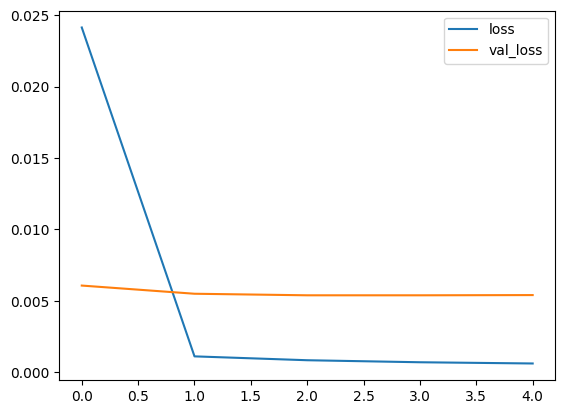

In [199]:
# Create the model
inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = keras.layers.LSTM(150, return_sequences= True)(inputs)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150, return_sequences=True)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150)(x)
outputs = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss="mse")
# model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    epochs = 5,
    batch_size = 32,
    validation_data=(X_val, y_val),
    verbose=1
)

# estimate the R2 on the test set
print("LSTM coefficient of determination of the prediction: ", r2_score(y_test, model.predict(X_test)))

# fit model
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


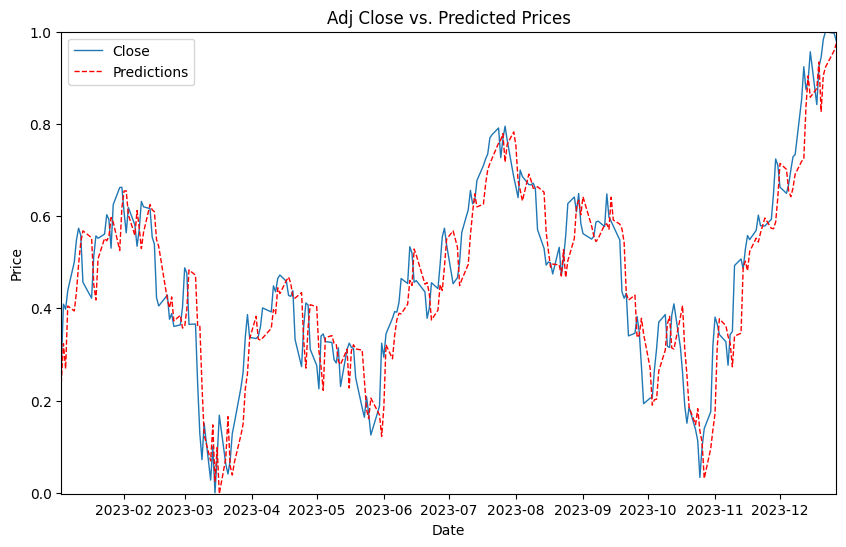

In [215]:
predictions = model.predict(X_test)
predictions = predictions.ravel().tolist()

graph_df = pd.DataFrame({
    'True': y_test, 
    'Predictions': predictions})

last_n_dates = df['Date'].tail(len(graph_df)).tolist()
last_n_dates
graph_df['Date'] = last_n_dates



#Plotting
x_min = graph_df['Date'].iloc[0]  # Replace with your desired minimum x-axis value
x_max = graph_df['Date'].iloc[-1]  # Replace with your desired maximum x-axis value
y_min = min(graph_df['True'].min(), graph_df['Predictions'].min())  # Replace with your desired minimum y-axis value
y_max = max(graph_df['True'].max(), graph_df['Predictions'].max())  # Replace with your desired maximum y-axis value

# Assuming your DataFrame is named df
# Replace 'Date', 'Close', and 'Predicted' with your actual column names
plt.figure(figsize=(10, 6))
plt.plot(graph_df['Date'], graph_df['True'], label='Close', linewidth=1)
plt.plot(graph_df['Date'], graph_df['Predictions'], label='Predictions', linestyle='dashed', color='red', linewidth=1)

# Customize the plot
plt.title('Adj Close vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Set x-axis and y-axis value ranges
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.grid(False)
plt.xticks(rotation=0)

# Show the plot
plt.show()
